In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
from vpython import *


ModuleNotFoundError: No module named 'vpython'

# LOADING DATA

In [2]:
train = pd.read_csv("train.csv")

# EDA

In [3]:
train.head()


,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
train.dtypes

id           int64
gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
target       int64
dtype: object

In [5]:
train.columns

Index(['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [6]:
train.describe().T


,count,mean,std,min,25%,50%,75%,max
id,414.0,206.500000,119.655756,0.000,103.250,206.500,309.750,413.00
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [7]:
train.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

## Correlations

<Axes: >

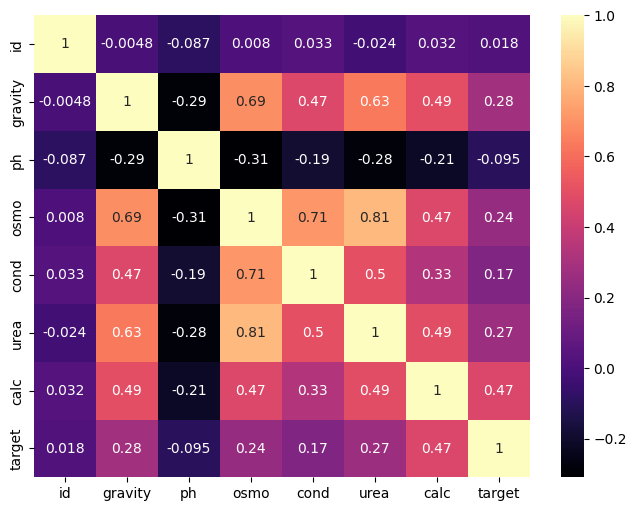

In [8]:
corr = train.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, cmap = 'magma', annot = True)

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


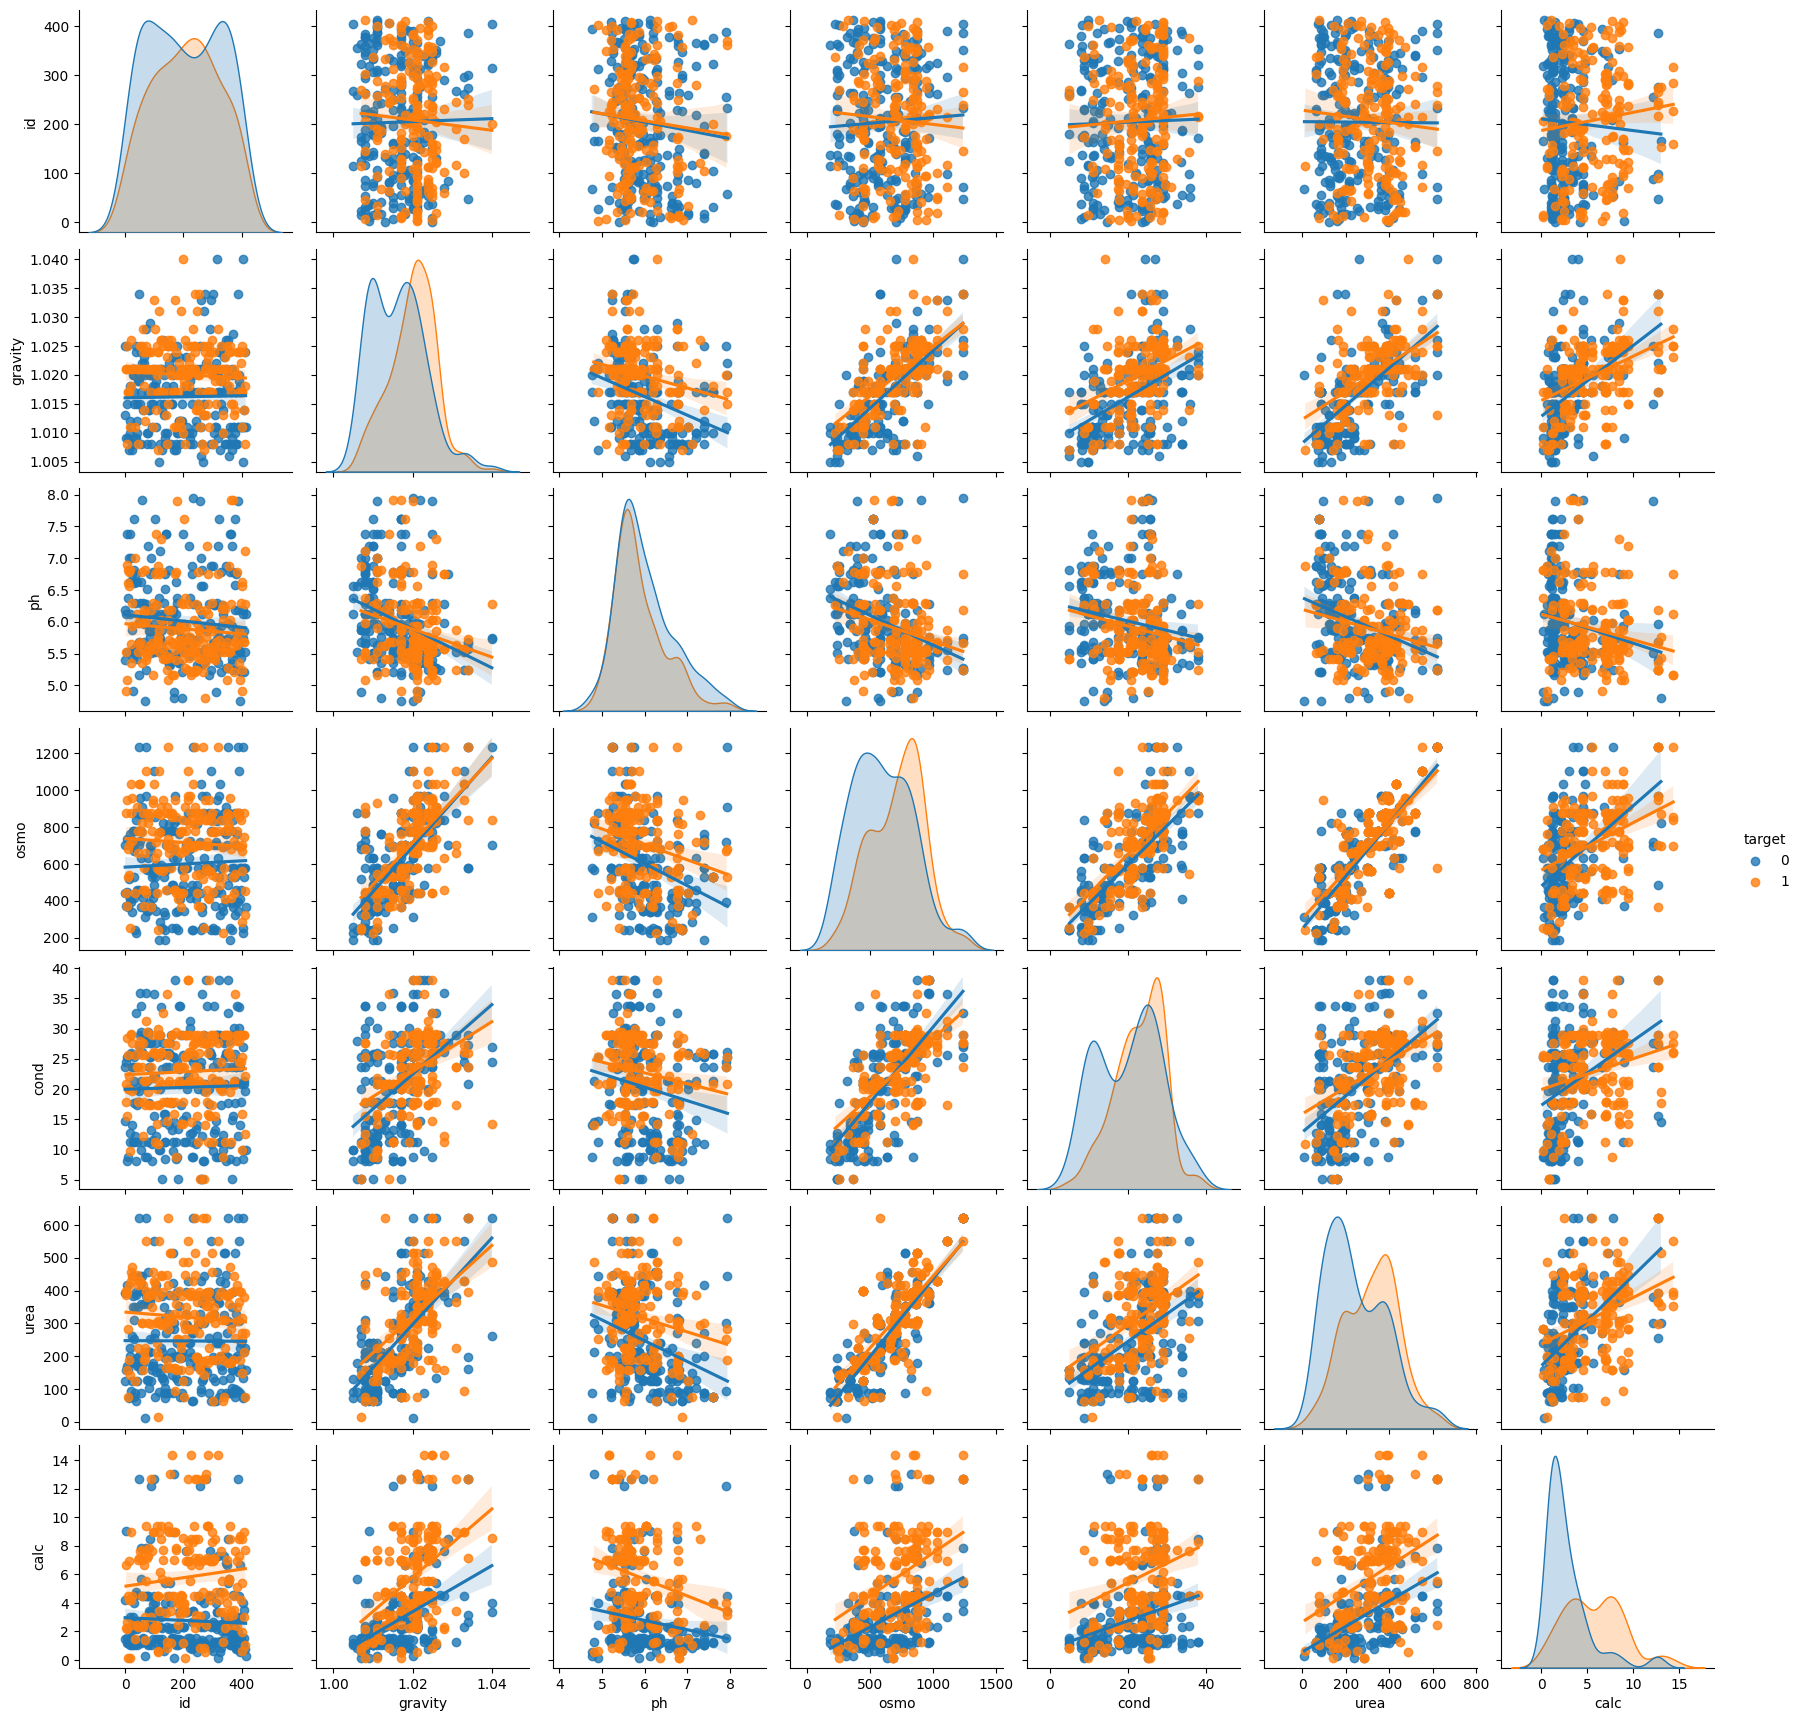

In [9]:
sns.pairplot(train, kind="reg", hue="target")

## Distribution of variables

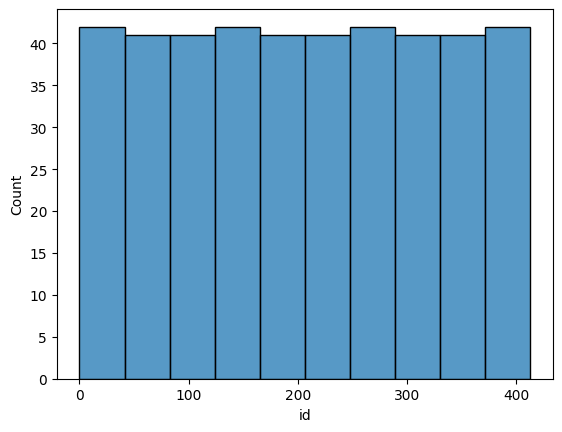

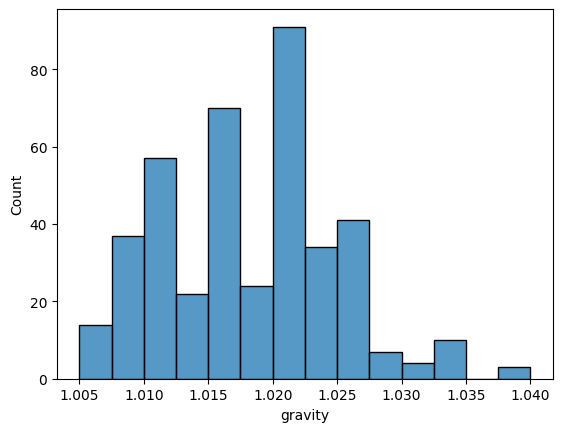

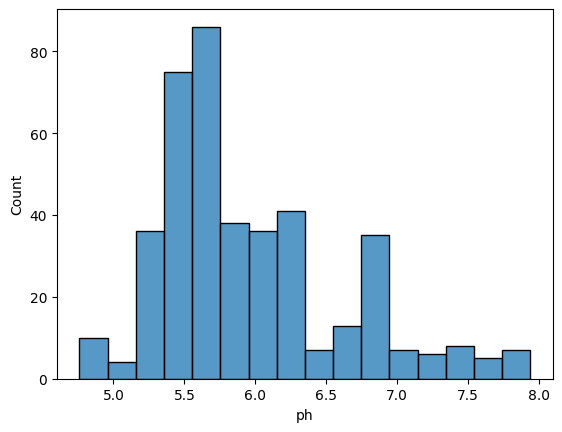

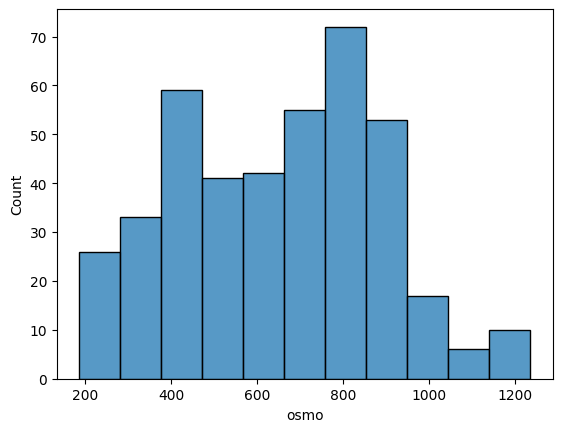

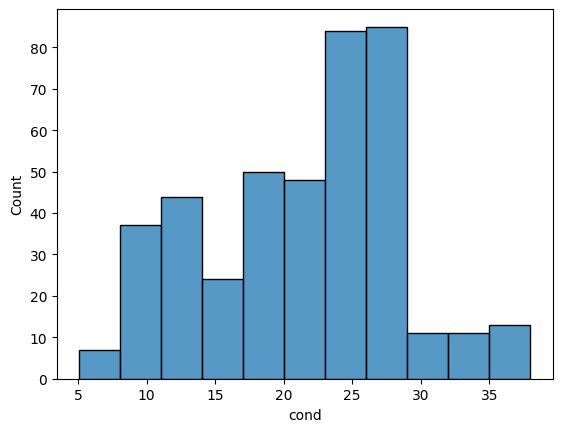

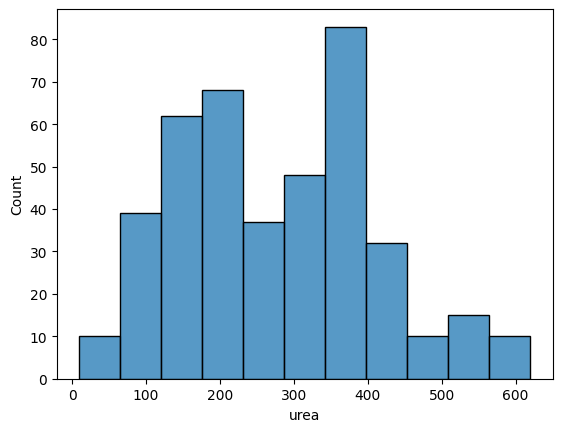

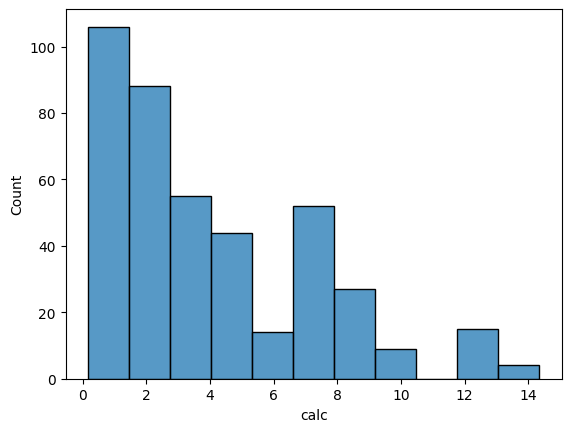

In [10]:
train_ind_var=train
train_ind_var = train_ind_var.iloc[:, :-1]

for column in train_ind_var.columns:
    sns.histplot(train_ind_var[column])
    plt.show()

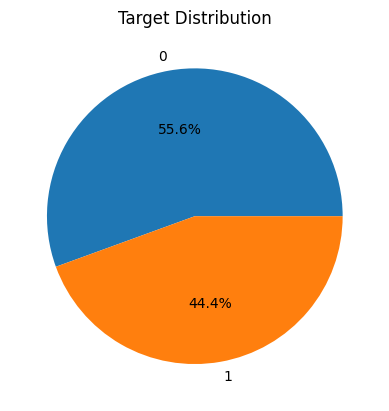

In [11]:
# Calculate the target distribution
target_dist = train['target'].value_counts(normalize=True)

# Create a pie chart
plt.pie(target_dist.values * 100, labels=target_dist.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

# DATA CLEANING

In [12]:
train.drop('id', inplace=True, axis=1)

## Outliers

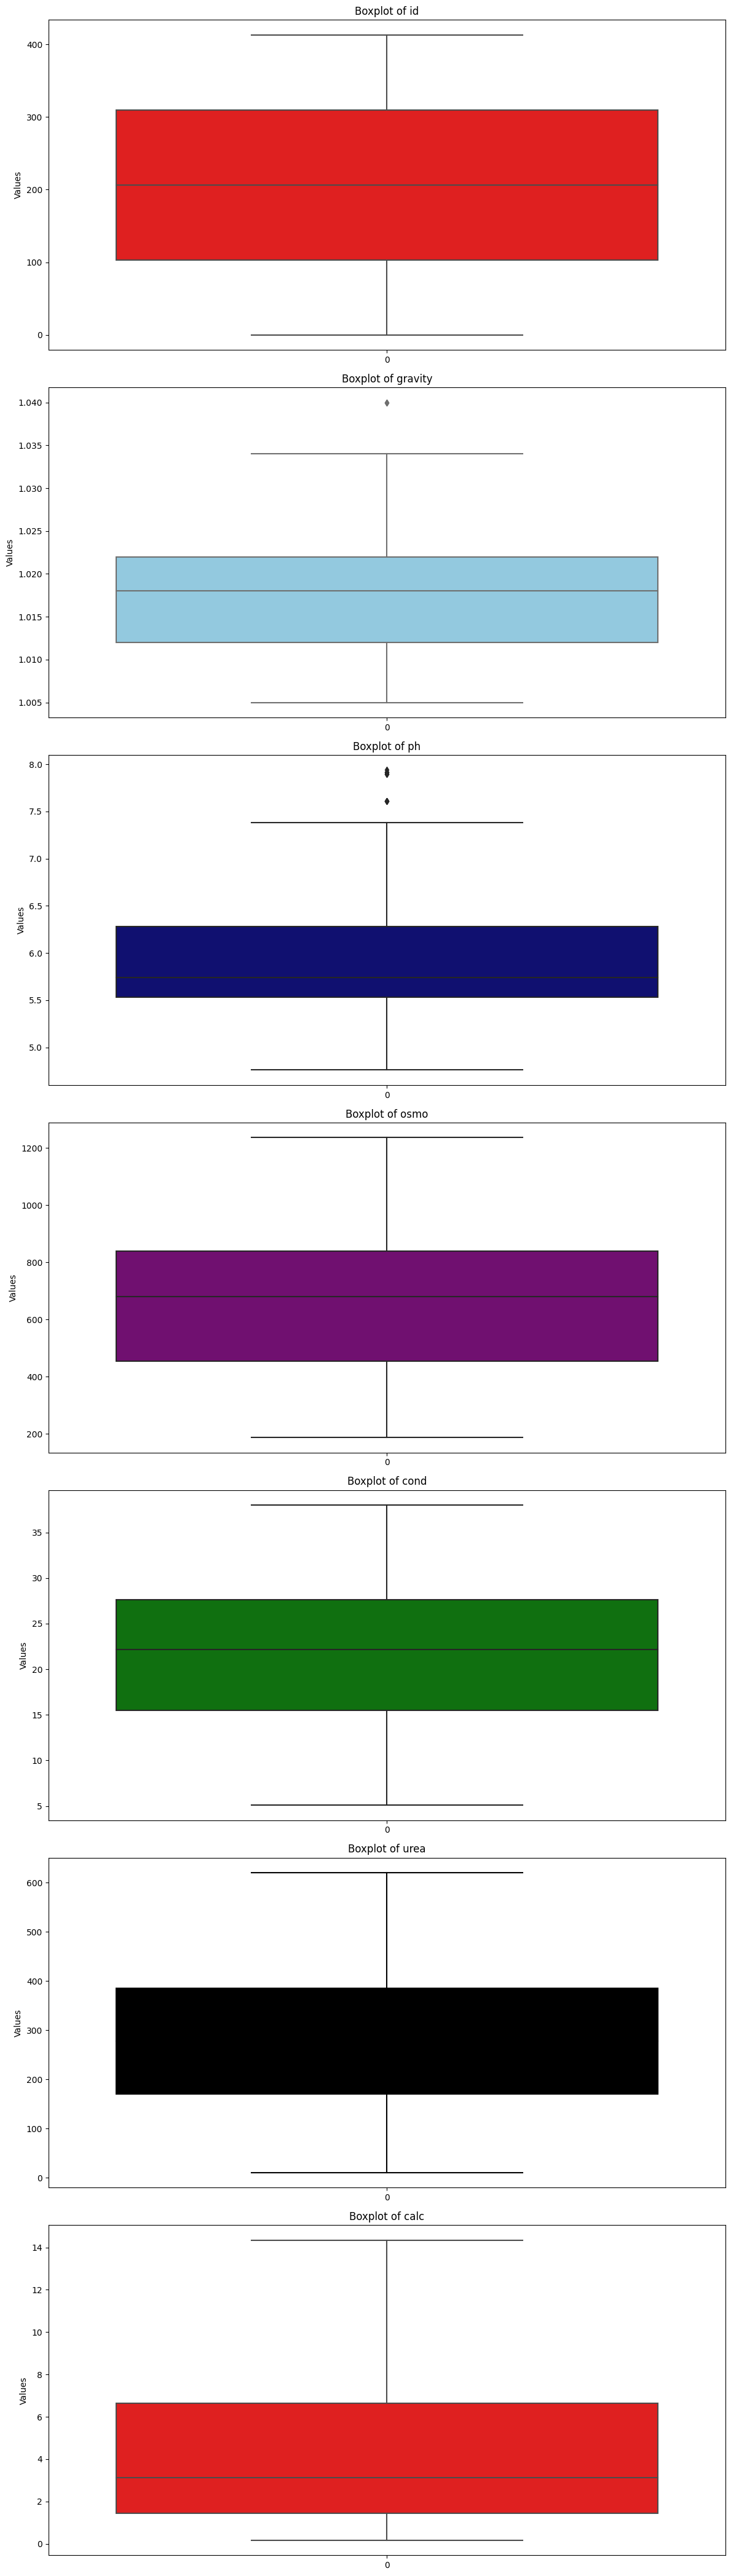

In [13]:
def plot_boxplots(dataframe):
    color_palette = ['red', 'skyblue', 'navy', 'purple', 'green', 'black']
    
    columns = dataframe.columns
    fig, axes = plt.subplots(nrows=len(columns), figsize=(12, 6 * len(columns)))

    for i, column in enumerate(columns):
        ax = axes[i]
        sns.boxplot(data=dataframe[column], color=color_palette[i % len(color_palette)], ax=ax)
        ax.set_title(f"Boxplot of {column}")
        ax.set_ylabel("Values")

    plt.tight_layout()
    plt.show()

plot_boxplots(train_ind_var)


In [14]:
"We also attempted to remove outliers, but it resulted in worse performance for the models. Therefore, we would prefer to skip this part."
#def outlier_removal(dataframe):
 #   for column in dataframe.columns:
  #      q1 = np.quantile(dataframe[column], 0.25)
   #     q3 = np.quantile(dataframe[column], 0.75)
    #    iqr = q3 - q1
     #   lower_tail = q1 - 1.5 * iqr
      #  upper_tail = q3 + 1.5 * iqr
       # dataframe = dataframe[(dataframe[column] >= lower_tail) & (dataframe[column] <= upper_tail)]
    # return dataframe

#train = outlier_removal(train)

'We also attempted to remove outliers, but it resulted in worse performance for the models. Therefore, we would prefer to skip this part.'

# PRE-PROCESSING AND SPLITTING DATA

In [15]:
X = train.drop(['target'], axis =1)
y = train['target']


X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state = True,test_size = 0.3)


# MODEL BUILDING -FIRST OVERVIEW

In [16]:
def compare_modelos(target_column):
    models = [
        DecisionTreeClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        KNeighborsClassifier(),
        SVC(random_state=0, probability=True),
        LogisticRegression(random_state=0),
        XGBClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB()
    ]
    models_comparison = {}

    for model in models:
        print(f"Model: {str(model)}\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_prob = model.predict_proba(X_valid)[:, 1] 
        accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
        print(classification_report(y_valid, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_valid, y_pred))
        print("-" * 30, "\n")
        models_comparison[str(model)] = {
            "Accuracy": accuracy_score(y_valid, y_pred),
            "F1 Score": f1_score(y_valid, y_pred, average="macro"),
            "Precision": precision_score(y_valid, y_pred, average="macro"),
            "Recall": recall_score(y_valid, y_pred, average="macro"),
            "ROC AUC": roc_auc_score(y_valid, y_prob),
            "Cross-Validation Accuracy": accuracies.mean()
        }

    # Create a DataFrame from the models_comparison dictionary
    df_comparison = pd.DataFrame.from_dict(models_comparison, orient='index')

    return df_comparison


df_comparison= compare_modelos('target')
print(df_comparison)

Model: DecisionTreeClassifier(random_state=0)

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        80
           1       0.54      0.69      0.61        45

    accuracy                           0.68       125
   macro avg       0.67      0.68      0.67       125
weighted avg       0.70      0.68      0.69       125

Confusion Matrix:
[[54 26]
 [14 31]]
------------------------------ 

Model: RandomForestClassifier(random_state=0)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.76      0.64      0.70        45

    accuracy                           0.80       125
   macro avg       0.79      0.77      0.77       125
weighted avg       0.80      0.80      0.80       125

Confusion Matrix:
[[71  9]
 [16 29]]
------------------------------ 

Model: KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.71   

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        80
           1       0.61      0.62      0.62        45

    accuracy                           0.72       125
   macro avg       0.70      0.70      0.70       125
weighted avg       0.72      0.72      0.72       125

Confusion Matrix:
[[62 18]
 [17 28]]
------------------------------ 

Model: AdaBoostClassifier()

              precision    recall  f1-score   support

           0       0.80      0.79      0.79        80
           1       0.63      0.64      0.64        45

    accuracy                           0.74       125
   macro avg       0.71      0.72      0.71       125
weighted avg       0.74      0.74      0.74       125

Confusion Matrix:
[[63 17]
 [16 29]]
------------------------------ 

Model: GradientBoostingClassifier()

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        80
           1       0.67      0.

## Fine-tuning the best models - RF and LG

## 1. RF - let's find out the best hyperparameters

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500,1000],  # try different numbers of trees
    'max_depth': [None, 5, 10],  # try different maximum depths
    'min_samples_split': [2, 5, 10],  # try different minimum samples split
    'min_samples_leaf': [1, 2, 4],  # try different minimum samples leaf
    'max_features': ['sqrt', 'log2']  # try different maximum features
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data using the best model
rf_predict_valid = best_model.predict(X_valid)
rf_prob_valid = best_model.predict_proba(X_valid)[:, 1]  # Probability estimates for positive class

# Calculate the accuracy, ROC AUC score, and print the confusion matrix for the test data
ac_rf_valid = accuracy_score(y_valid, rf_predict_valid)
roc_auc_rf_valid = roc_auc_score(y_valid, rf_prob_valid)
cm_rf_valid = confusion_matrix(y_valid, rf_predict_valid)

print("Best Parameters:", best_params)
print("Accuracy (test):", ac_rf_valid)
print("ROC AUC (test):", roc_auc_rf_valid)
print("Confusion Matrix (test):\n", cm_rf_valid)

'''Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1000}
Accuracy (test): 0.792
ROC AUC (test): 0.845
Confusion Matrix (test):
 [[72  7]
 [19 26]]'''

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy (test): 0.792
ROC AUC (test): 0.8436111111111111
Confusion Matrix (test):
 [[73  7]
 [19 26]]


"Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1000}\nAccuracy (test): 0.792\nROC AUC (test): 0.845\nConfusion Matrix (test):\n [[72  7]\n [19 26]]"

Normalizing data

In [18]:
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(X)

train_df_scaled.mean()
np.mean(train_df_scaled, axis=0)
np.std(train_df_scaled, axis=0)

X_train,X_valid,y_train,y_valid = train_test_split(train_df_scaled,y,random_state = True,test_size = 0.3)

'''After normalizing data, we tried out the previous model and it had a slightly better RF_ROC_AUC score but not a big difference'''

'After normalizing data, we tried out the previous model and it had a slightly better RF_ROC_AUC score but not a big difference'

In [19]:
train1 = train.drop('ph', axis=1)

X = train1.drop(['target'], axis =1)
y = train1['target']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state = True,test_size = 0.3)

rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=15,
                                       min_samples_split=5, min_samples_leaf=4,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       bootstrap=True, random_state=42)

rf_model.fit(X_train, y_train)
rf_predict_valid = rf_model.predict(X_valid)
rf_prob_valid = rf_model.predict_proba(X_valid)[:, 1]  
ac_rf_valid = accuracy_score(y_valid, rf_predict_valid)
roc_auc_rf_valid = roc_auc_score(y_valid, rf_prob_valid)
cm_rf_valid = confusion_matrix(y_valid, rf_predict_valid)

print("Accuracy (test):", ac_rf_valid)
print("ROC AUC (test):", roc_auc_rf_valid)
print("Confusion Matrix (test):\n", cm_rf_valid)
'''Accuracy (test): 0.8
ROC AUC (test): 0.8475
Confusion Matrix (test):
 [[73  7]
 [18 27]]'''

Accuracy (test): 0.808
ROC AUC (test): 0.838888888888889
Confusion Matrix (test):
 [[72  8]
 [16 29]]


'Accuracy (test): 0.8\nROC AUC (test): 0.8475\nConfusion Matrix (test):\n [[73  7]\n [18 27]]'

# 2. Logistic regression

In [20]:
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10.0],  
    'solver': ['liblinear', 'lbfgs']  
}

grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)


lr_predict_valid = best_model.predict(X_valid)
lr_prob_valid = best_model.predict_proba(X_valid)[:, 1]  


ac_lr_valid = accuracy_score(y_valid, lr_predict_valid)
roc_auc_lr_valid = roc_auc_score(y_valid, lr_prob_valid)
cm_lr_valid = confusion_matrix(y_valid, lr_predict_valid)

print("Best Parameters:", best_params)
print("Accuracy (test):", ac_lr_valid)
print("ROC AUC (test):", roc_auc_lr_valid)
print("Confusion Matrix (test):\n", cm_lr_valid)

'''Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Accuracy (test): 0.784
ROC AUC (test): 0.858
Confusion Matrix (test):
 [[75  5]
 [22 23]]'''


Best Parameters: {'C': 1.0, 'solver': 'liblinear'}
Accuracy (test): 0.776
ROC AUC (test): 0.8594444444444445
Confusion Matrix (test):
 [[77  3]
 [25 20]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


"Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}\nAccuracy (test): 0.784\nROC AUC (test): 0.858\nConfusion Matrix (test):\n [[75  5]\n [22 23]]"

In [21]:

logreg = LogisticRegression(C=1.0, solver='liblinear', class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=400,
                            multi_class='ovr', n_jobs=1, penalty='l2', random_state=22, tol=0.0001, verbose=0, warm_start=False)

logreg.fit(X_train, y_train)
lr_predict_valid = logreg.predict(X_valid)
lr_prob_valid = logreg.predict_proba(X_valid)[:, 1] 
ac_lr_valid = accuracy_score(y_valid, lr_predict_valid)
roc_auc_lr_valid = roc_auc_score(y_valid, lr_prob_valid)
cm_lr_valid = confusion_matrix(y_valid, lr_predict_valid)

print("Accuracy (validation):", ac_lr_valid)
print("ROC AUC (validation):", roc_auc_lr_valid)
print("Confusion Matrix (validation):\n", cm_lr_valid)


Accuracy (validation): 0.776
ROC AUC (validation): 0.8594444444444445
Confusion Matrix (validation):
 [[77  3]
 [25 20]]


# FEATURE ENGINEERING to improve score

In [22]:
train1 = train.drop('ph', axis=1)

In [23]:
X = train1.drop(['target'], axis =1)
y = train1['target']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state = True,test_size = 0.3)

In [24]:

logreg = LogisticRegression(C=1.0, solver='liblinear', class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=400,
                            multi_class='ovr', n_jobs=1, penalty='l2', random_state=22, tol=0.0001, verbose=0, warm_start=False)
logreg.fit(X_train, y_train)
lr_predict_valid = logreg.predict(X_valid)
lr_prob_valid = logreg.predict_proba(X_valid)[:, 1] 
ac_lr_valid = accuracy_score(y_valid, lr_predict_valid)
roc_auc_lr_valid = roc_auc_score(y_valid, lr_prob_valid)
cm_lr_valid = confusion_matrix(y_valid, lr_predict_valid)

print("Accuracy (validation):", ac_lr_valid)
print("ROC AUC (validation):", roc_auc_lr_valid)
print("Confusion Matrix (validation):\n", cm_lr_valid)
'''Accuracy (validation): 0.776
ROC AUC (validation): 0.859
Confusion Matrix (validation):
 [[77  3]
 [25 20]]'''
 
'''In this context, where the accuracy of predictions is crucial, the logistic regression model exhibited particularly significant deficiencies by incorrectly predicting 25 instances as negative. Considering this, we have decided to opt for the Random Forest model instead, despite it achieving a lower ROC AUC score compared to the logistic regression model.'''
'''We did not normalize the data or perform feature engineering because it did not improve the outcome based on our research'''

Accuracy (validation): 0.776
ROC AUC (validation): 0.8594444444444445
Confusion Matrix (validation):
 [[77  3]
 [25 20]]


'We did not normalize the data or perform feature engineering because it did not improve the outcome based on our research'

# SUBMITTING PREDICTIONS

In [28]:
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')
test.drop('id', inplace=True, axis=1)
test.drop('ph', inplace=True, axis=1)
test_predictions = rf_model.predict(test)
submit['target'] = test_predictions
submit.to_csv('submission.csv', index=False)
